In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from VMOSfunc import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import seaborn as sns
import cmocean
import cmasher as cmr
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = "Serif"

In [2]:
def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>5030*k) & (wo_wave<5050*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact


In [3]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2=False):
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave<5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 0
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss,x0=p_init,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Hb_error,amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_Hb_br_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,amp_Hb1_error,amp_Fe5018_1_error,vel_Hb1_error,vel_sigma_Hb1_error,amp_Hb2_error,amp_Fe5018_2_error,vel_Hb2_error,vel_sigma_Hb2_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

In [4]:
def red_data_err(data,model,res,x0,y0,x_m,y_m,muse_sampling_size,box_size=3):
    (y_cen,x_cen)=(int(round(y_m)),int(round(x_m)))
    data_red = data[y_cen-box_size:y_cen+box_size,x_cen-box_size:x_cen+box_size]
    mod_red =model[y_cen-box_size:y_cen+box_size,x_cen-box_size:x_cen+box_size]
    residual_red =res[y_cen-box_size:y_cen+box_size,x_cen-box_size:x_cen+box_size]
    (x0,y0)=(x0-14,y0-14)
    #plt.imshow(data_red,origin='lower')
    #plt.show()
    err_red = (data_red - mod_red)/residual_red
    return data_red,mod_red,residual_red,err_red,x0,y0 

In [5]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,broad2=False,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS/Aperture Spectrum"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit
    if amp_Hb_br_fit <0:
        amp_Hb_br_fit = 0
    else:
        amp_Hb_br_fit = amp_Hb_br_fit
    k = 1+z
    new_k = 1+ (vel_OIII_fit/300000)
    select = (wo_wave>4750*new_k) & (wo_wave < 5090*new_k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit

    #plt.style.use('ggplot')
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['axes.edgecolor'] = 'k'
    fig = plt.figure(figsize=(15, 10)) 
    gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1]) 
    
    #ax1 = plt.subplot(gs[0])
    #ax2 = plt.subplot(gs[1])
    ax1 = fig.add_axes([0.1, 0.29, 0.84, 0.7]) # main axes
    ax2 = fig.add_axes([0.1, 0.08, 0.84, 0.2]) # inset axes

    plt.setp(ax1.get_xticklabels(), visible=False)
    #ax1.xaxis.set_ticks_position('bottom') 
    #ax1.xaxis.set_label_position('bottom') 
    ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax1.minorticks_on()
    ax1.plot(wo_wave[select]/new_k,data[select],'r-',label='Spectrum',drawstyle='steps-mid',linewidth=3,color='gray')
    ax1.plot(wo_wave[select]/new_k,fit,'r',linestyle='dashed',label='Fit')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),color='green',linestyle='--',label='Narrow core')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='Broad wing',linestyle='-.')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_blr_gauss(wo_wave[select],amp_Hb1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':',label='BLR')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_blr_gauss(wo_wave[select],amp_Hb2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe4923_gauss(wo_wave[select],amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe4923_gauss(wo_wave[select],amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe5018_gauss(wo_wave[select],amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe5018_gauss(wo_wave[select],amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.set_xlim(4760,5090)
    ax1.set_ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
    ax1.text(4890,0.95*np.max(data),"%s"%(obj),fontsize=21)
    ax1.legend(facecolor='white', framealpha=1, fontsize=17, loc='upper left',borderpad=1)

    ax2.plot(wo_wave[select]/new_k,residual/error[select],drawstyle='steps-mid',color='black')
    ax2.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax2.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax2.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax2.minorticks_on()
    ax2.axhline(y=0.0, color='maroon', linestyle='--')   
    ax2.axhspan(-3, 3, alpha=0.2, color='brown')
    ax2.set_xlim(4760,5090)
    ax2.set_ylim(-8,8)    
    ax2.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
    ax2.set_ylabel(r"Residual/Error",fontsize=21)
    ax2.legend(fontsize=17)
   
    plt.tight_layout(pad=0.001, h_pad=0.001, w_pad=None)
    fig.savefig('%s/%s_aperture_spectra.png'%(destination_path_cube,obj),overwrite=True)
    

In [6]:
def algorithm_script(obj,z,broad2,prefix_path_cube="/home/rickeythecat/ftp.hidrive.strato.com/users/login-carsftp/IFU_data",destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    print ('%s'%(obj))
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s.wo_absorption_blue.fits'%(destination_path_cube,obj,obj)) 
    #(blue_cube,blue_err,blue_wave,blue_header) = loadCube('%s/VIMOS_O3Ha/%s/%s_blue.rscube.fits'%(prefix_path_cube,obj,obj))  
    [x0,y0] = agn_location(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(x0),int(y0)]#brightest_pixel(wo_cube)
    data = wo_cube[:,brightest_pixel_y-2:brightest_pixel_y+3,brightest_pixel_x-2:brightest_pixel_x+3]
    error = wo_err[:,brightest_pixel_y-2:brightest_pixel_y+3,brightest_pixel_x-2:brightest_pixel_x+3]
    (int_spectrum,int_err) = int_spec(data,error)
    factor = scale_factor_spectrum(z,int_spectrum,int_err,wo_wave)
    int_err = factor*int_err
    popt_full_fit = full_specpar('%s/%s/%s_nonspectro_central_fit.fits'%(destination_path_cube,obj,obj))
    plot(obj,wo_wave,int_spectrum,int_err,z,popt_full_fit,broad2)

No handles with labels found to put in legend.


HE1310-1051


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


HE1338-1423


No handles with labels found to put in legend.
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


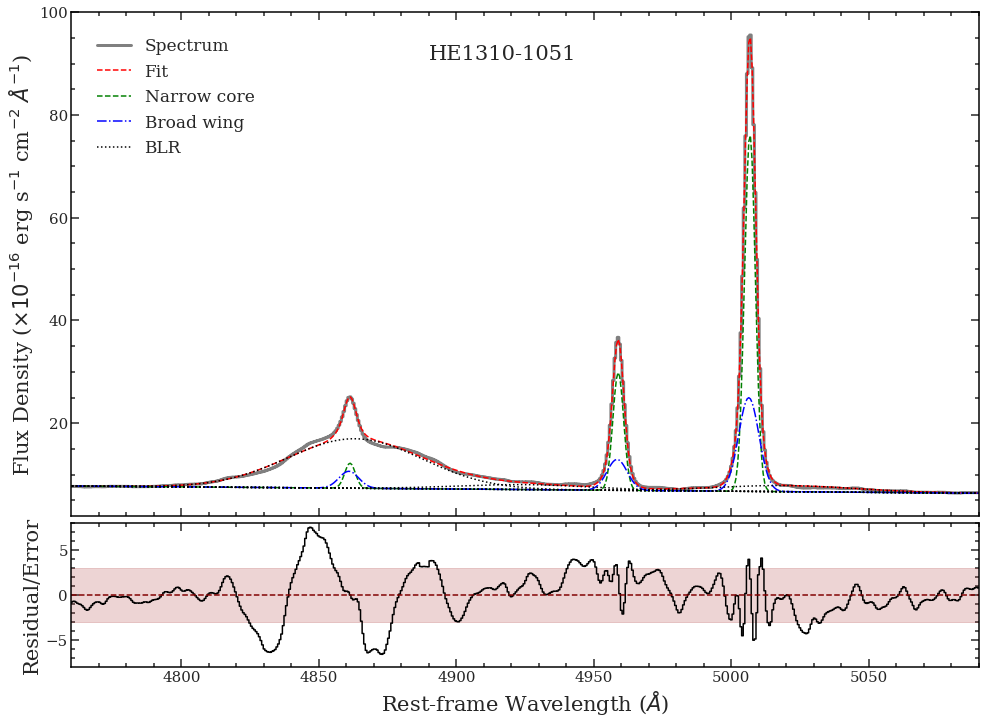

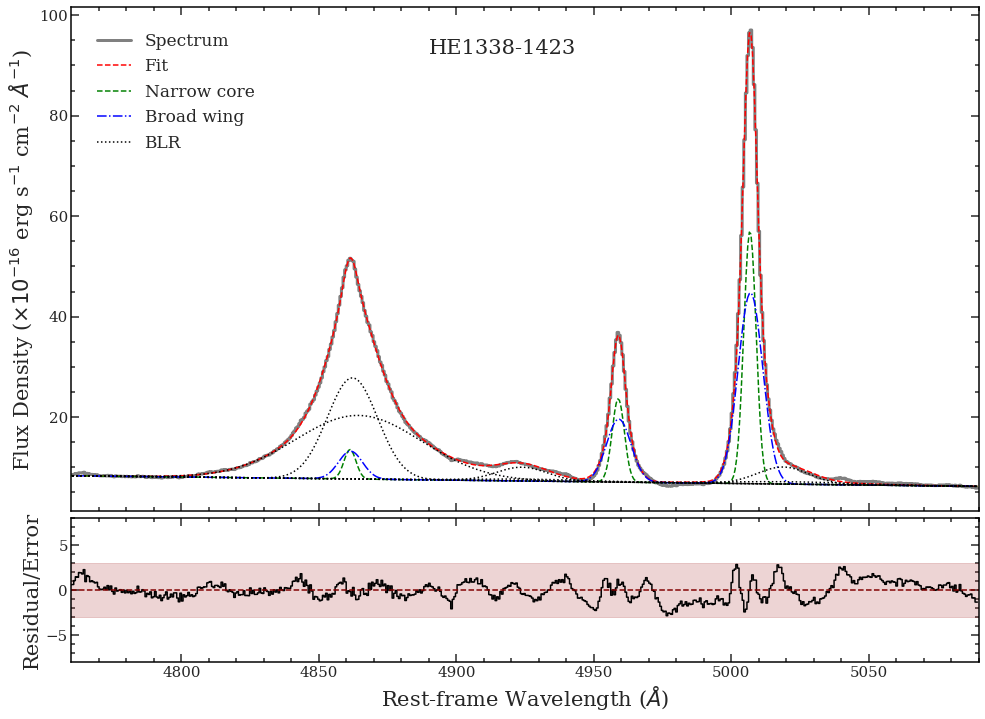

In [7]:
z = {"HE1310-1051":0.03427,"HE1338-1423":0.04179}

objs = z.keys()

broad2= {'HE1310-1051':False,'HE1338-1423':True}

for obj in objs:
     algorithm_script(obj,z[obj],broad2[obj]) 
